In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import StockHistoricalDataClient

In [2]:
# Alpaca API credentials
api_key = "PK2DSD4BN8QNOYWSC5I1"
secret_key = "eGSHvlwHLcuf24k0cTKXDPYFMjs3n1per4SsAys8"

In [3]:
client = StockHistoricalDataClient(api_key, secret_key)

In [4]:
# MACD computation
def compute_macd(data, fast=12, slow=26, signal=9):
    data['ema_fast'] = data['close'].ewm(span=fast, adjust=False).mean()
    data['ema_slow'] = data['close'].ewm(span=slow, adjust=False).mean()
    data['macd'] = data['ema_fast'] - data['ema_slow']
    data['signal'] = data['macd'].ewm(span=signal, adjust=False).mean()
    data['histogram'] = data['macd'] - data['signal']
    return data

In [5]:
# Fetch historical stock data for MAG6
symbols = ["AAPL", "GOOGL", "AMZN", "META", "MSFT", "NVDA"]
start_date = dt.datetime.now() - dt.timedelta(days=365)
end_date = dt.datetime.now()

request_params = StockBarsRequest(
    symbol_or_symbols=symbols,
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date
)

bars = client.get_stock_bars(request_params).df
stock_dic = {}
scaler = MinMaxScaler(feature_range=(0, 1))

for symbol in symbols:
    df = bars[bars.index.get_level_values(0) == symbol].copy()
    df.reset_index(inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df.set_index('timestamp', inplace=True)
    df = compute_macd(df)
    df[['close', 'macd', 'signal']] = scaler.fit_transform(df[['close', 'macd', 'signal']])
    stock_dic[symbol] = df

In [6]:
# Prepare dataset for LSTM (50 days)
sequence_length = 50

def create_sequences(data):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])
    return np.array(X), np.array(y)

X_train, y_train = [], []
for symbol in symbols:
    train_data = stock_dic[symbol][['close', 'macd', 'signal']].values
    X, y = create_sequences(train_data)
    X_train.append(X)
    y_train.append(y)

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0).reshape(-1, 1)

In [7]:
# Build LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(sequence_length, 3)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=16)

Epoch 1/10


C:\Users\sassy\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.0903
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0163
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0127
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0135
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0110
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0083
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0081
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0112
Epoch 9/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0076
Epoch 10/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0065


In [8]:
# Predict future prices for each stock
predictions = {}
metrics = {}
for symbol in symbols:
    test_data = stock_dic[symbol][['close', 'macd', 'signal']].values
    X_test, y_test = create_sequences(test_data)
    pred = model.predict(X_test)
    predictions[symbol] = pred
    
    # Convert predictions to binary (up/down movement)
    y_test_binary = np.where(y_test[1:] > y_test[:-1], 1, 0)
    pred_binary = np.where(pred[1:] > pred[:-1], 1, 0)
    
    # Calculate performance metrics
    mae = mean_absolute_error(y_test, pred)
    mse = mean_squared_error(y_test, pred)
    accuracy = accuracy_score(y_test_binary, pred_binary)
    precision = precision_score(y_test_binary, pred_binary)
    recall = recall_score(y_test_binary, pred_binary)
    f1 = f1_score(y_test_binary, pred_binary)
    
    metrics[symbol] = {'MAE': mae, 'MSE': mse, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [10]:
# Print evaluation metrics for each stock
for symbol, metric in metrics.items():
    print(f"{symbol} - ")
    print(f"  MAE: {metric['MAE']:.4f}")
    print(f"  MSE: {metric['MSE']:.4f}")
    print(f"  Accuracy: {metric['Accuracy']:.4f}")
    print(f"  Precision: {metric['Precision']:.4f}")
    print(f"  Recall: {metric['Recall']:.4f}")
    print(f"  F1 Score: {metric['F1 Score']:.4f}")
    print('-' * 20)

AAPL - 
  MAE: 0.0406
  MSE: 0.0027
  Accuracy: 0.5176
  Precision: 0.5780
  Recall: 0.5575
  F1 Score: 0.5676
--------------------
GOOGL - 
  MAE: 0.0607
  MSE: 0.0063
  Accuracy: 0.4774
  Precision: 0.5047
  Recall: 0.5143
  F1 Score: 0.5094
--------------------
AMZN - 
  MAE: 0.0483
  MSE: 0.0041
  Accuracy: 0.5075
  Precision: 0.5189
  Recall: 0.5392
  F1 Score: 0.5288
--------------------
META - 
  MAE: 0.0379
  MSE: 0.0023
  Accuracy: 0.5025
  Precision: 0.5487
  Recall: 0.5636
  F1 Score: 0.5561
--------------------
MSFT - 
  MAE: 0.0701
  MSE: 0.0081
  Accuracy: 0.5276
  Precision: 0.5631
  Recall: 0.5421
  F1 Score: 0.5524
--------------------
NVDA - 
  MAE: 0.0200
  MSE: 0.0038
  Accuracy: 0.4724
  Precision: 0.4896
  Recall: 0.4563
  F1 Score: 0.4724
--------------------


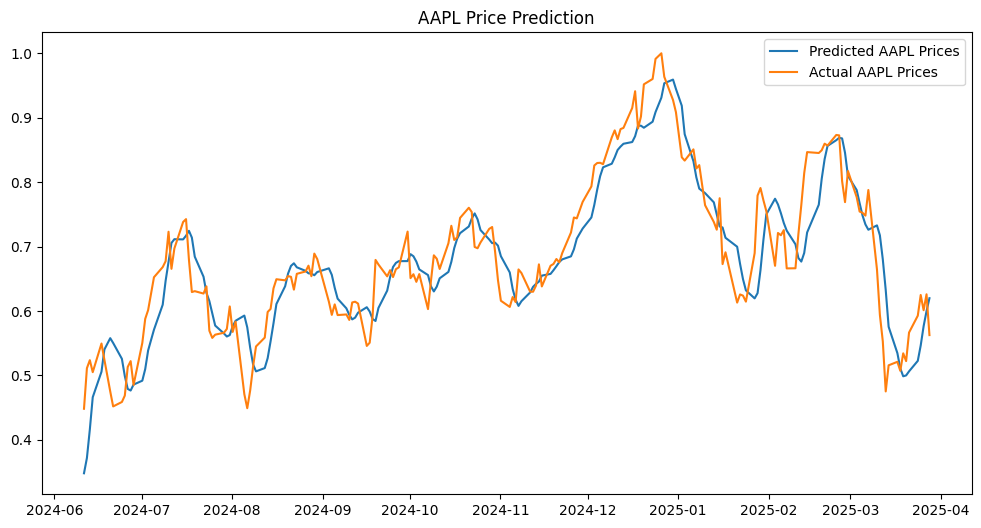

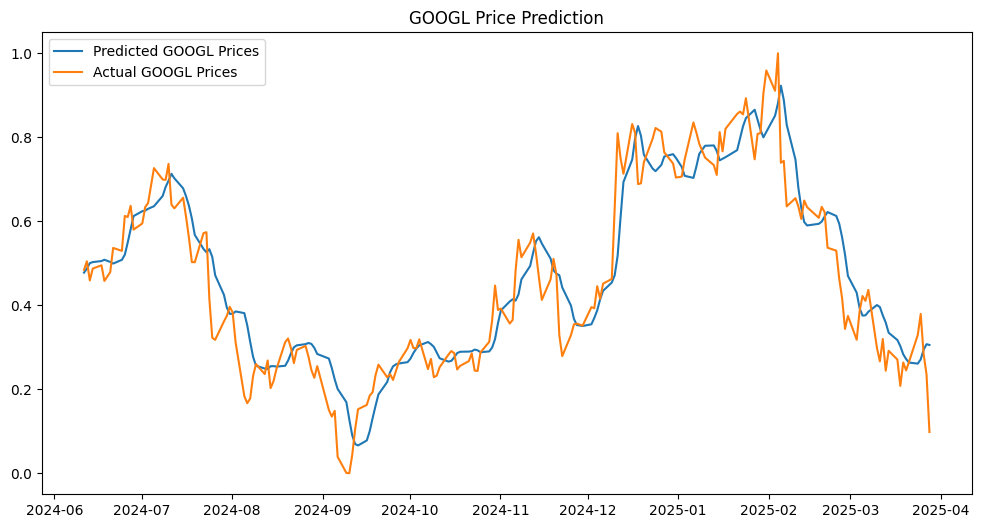

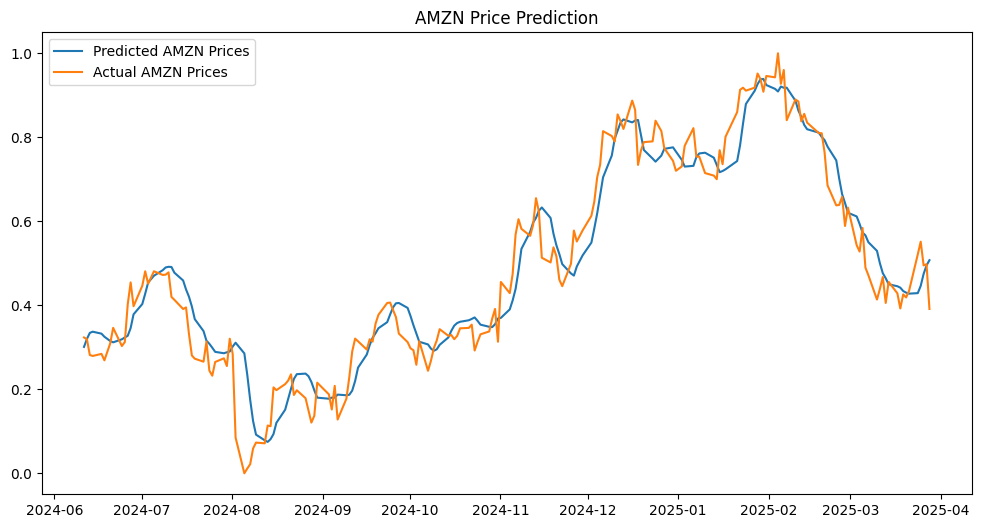

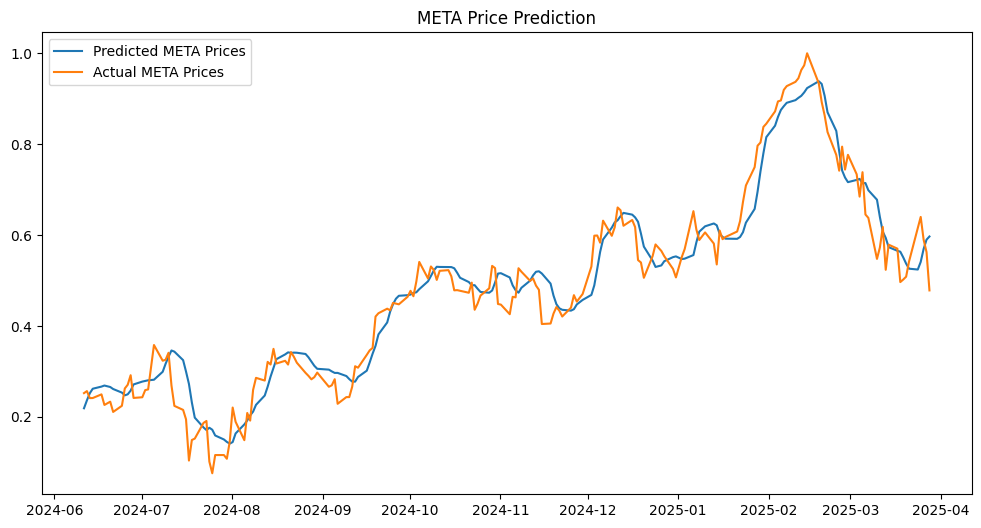

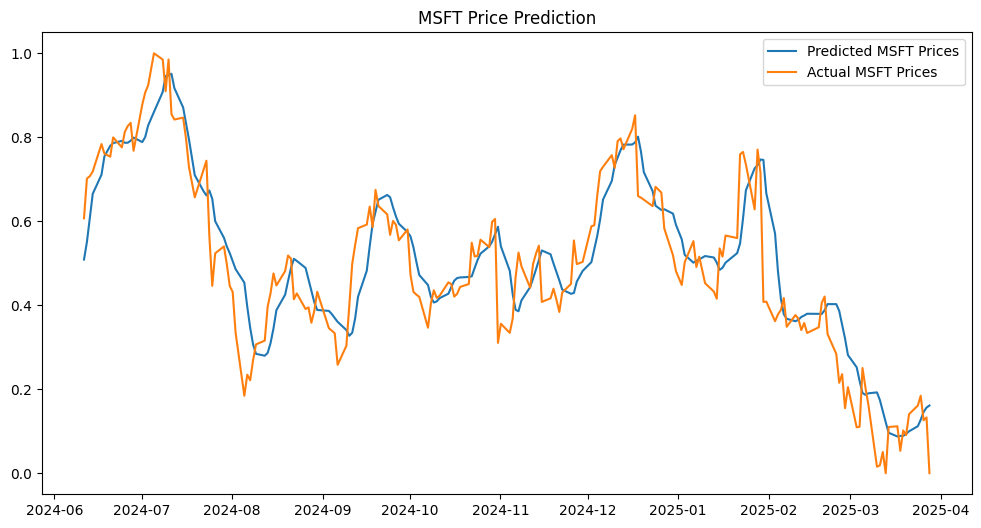

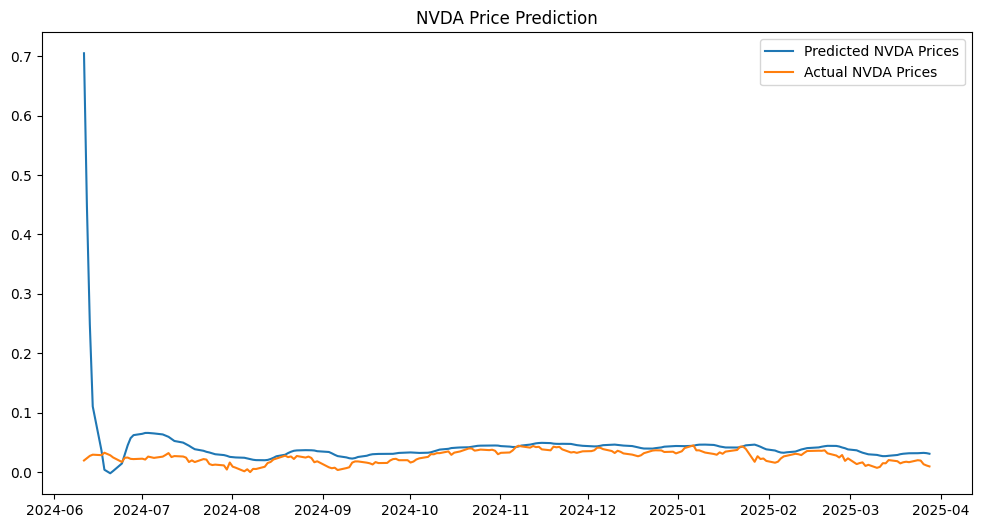

In [11]:
# Plot predictions vs actual prices for each stock
for symbol in symbols:
    plt.figure(figsize=(12, 6))
    plt.plot(stock_dic[symbol].index[-len(predictions[symbol]):], predictions[symbol], label=f'Predicted {symbol} Prices')
    plt.plot(stock_dic[symbol].index[-len(predictions[symbol]):], stock_dic[symbol]['close'].iloc[-len(predictions[symbol]):], label=f'Actual {symbol} Prices')
    plt.legend()
    plt.title(f'{symbol} Price Prediction')
    plt.show()
